# 12: Hail Average Magnitude Forecast | Region: U.S. West
---

## 1. Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [3]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [4]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [5]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [6]:
# Casting the begin_date_time to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [7]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Hail in the West (2000-2022)

In [8]:
hail = all_storms[all_storms['event_type'] == 'Hail']

hail = hail[hail['region'] == 'West']

hail = hail[hail.index > '2000']

In [9]:
hail

,state,region,event_type,magnitude
begin_date_time,,,,
2000-02-14 16:06:00,Idaho,West,Hail,1.00
2000-02-14 16:15:00,Idaho,West,Hail,1.00
2000-02-16 17:23:00,California,West,Hail,0.75
2000-02-22 16:05:00,Colorado,West,Hail,1.00
2000-02-22 16:30:00,Colorado,West,Hail,0.75
...,...,...,...,...
2021-10-05 18:12:00,Arizona,West,Hail,0.88
2021-10-05 18:42:00,Arizona,West,Hail,0.75
2021-10-05 18:42:00,Arizona,West,Hail,0.75


### 3.3. Resampling to Quarterly Averages

In [10]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [11]:
# Resampling to quarterly averages
hail = hail.resample('Q').mean()

# Renaming the column to 'avg_mag'
hail = hail.rename(columns={'magnitude': 'avg_mag'})

In [12]:
# Checking for null values as a result of the resampling

hail.isnull().sum()

avg_mag    1
dtype: int64

In [13]:
# Using the interpolate function to fill in the missing values with the mean of the previous value and the next value

hail = hail.interpolate()

In [14]:
hail

,avg_mag
begin_date_time,
2000-03-31,1.007143
2000-06-30,1.024296
2000-09-30,1.153859
2000-12-31,0.912973
2001-03-31,0.858636
...,...
2020-12-31,0.880000
2021-03-31,0.475333
2021-06-30,1.304952


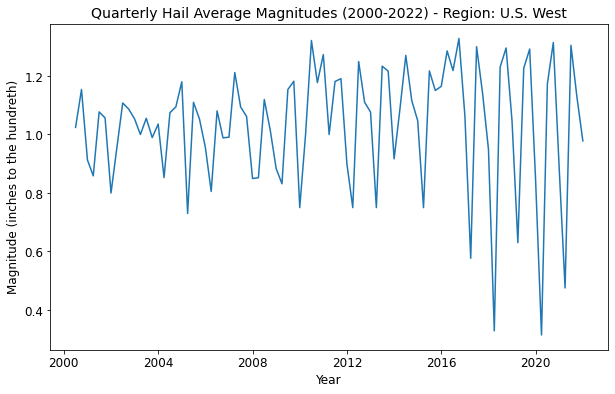

In [37]:
# Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. West

plot_series(hail, ['avg_mag'], title='Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. West', xlab='Year', ylab='Magnitude (inches to the hundreth)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

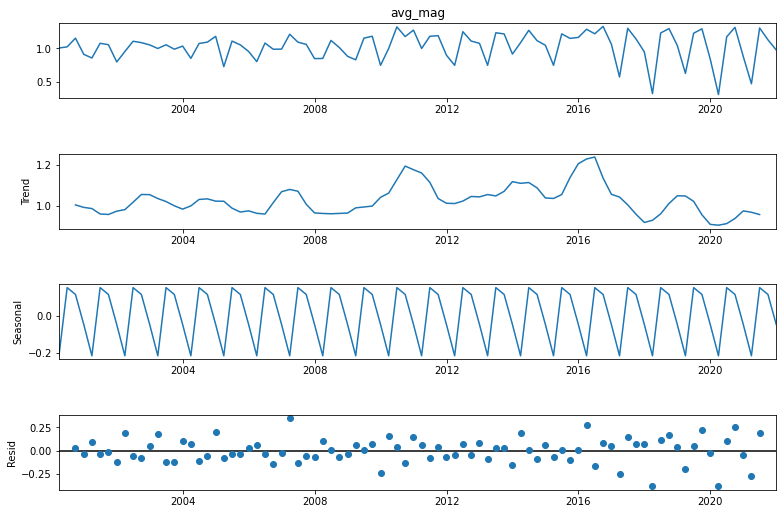

In [18]:
decomp = seasonal_decompose(hail['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see a bit of fluctuation. Up until 2016, we see an increasing trend, but a decreasing trend in the years after.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model, and the spread of residuals get greater after 2016.

### 4.2. Autocorrelation

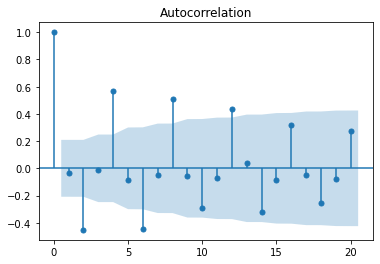

In [21]:
plot_acf(hail['avg_mag']);

For trend, there are a few lags that extend beyond the blue region, which represents a 95% confidence interval, but they're not consistent enough in the early lags for there to seem to be a trend.

For seasonality, the fluctuations do seem to occur with a fixed and known frequency and therefore, indicates that there may be seasonality present in the data.

For lags, it seems that none of the lags will be useful to include in the model, as the first and most important lag does not extend beyond the blue region.

### 4.3. Partial Autocorrelation

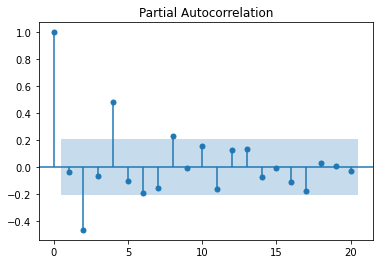

In [22]:
plot_pacf(hail['avg_mag']);

For seasonality, contrary to the autocorrelation, the fluctuations no longer occur with a fixed and known frequency and therefore, determines that there is no seasonality present.

For lags, it still seems that none of the lags will be useful to include in the model.

### 4.4. Stationarity

In [16]:
# Dickey-Fuller Stationarity Test

adfuller(hail['avg_mag'])

(-2.3608693920640142,
 0.1530865856263659,
 7,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 -50.468521157489334)

The first 2 statistics of the test results tell me that the data is not stationary.

The 'test statistic', the first statistic, needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is not. The p-value, the second statistic, needs to be less than the alpha of 0.05, and it is not. As a result, I'll need to difference the data.

### 4.5. Differencing

In [19]:
# Differencing the data

hail['first_diff'] = hail['avg_mag'].diff()

In [20]:
# Dropping any null values as a result of the differencing

hail.dropna(inplace=True)

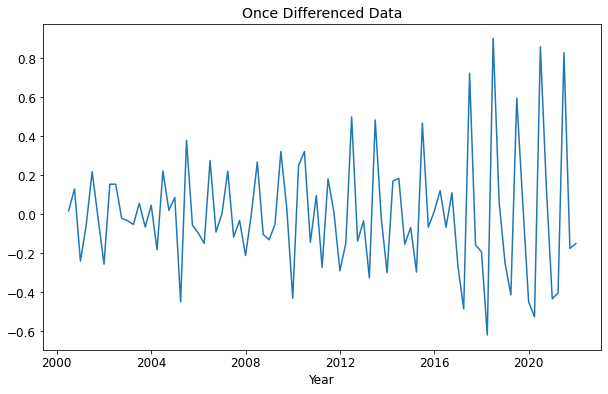

In [21]:
plot_series(hail, ['first_diff'], title='Once Differenced Data', xlab='Year', steps=4)

In [22]:
# Checking for the stationarity of the once differenced data

adfuller(hail['first_diff'])

(-7.028512526975887,
 6.27305323256814e-10,
 6,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 -45.81344205380071)

The test statistic is now less than the critical values and the p-value is less than the alpha of 0.05. The data is now stationary and can be modeled on with ARIMA.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

In [23]:
y_train, y_test = train_test_split(hail['first_diff'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

Because I needed to difference the data once, I know that the d parameter for the ARIMA model is 1. Given that, I'll run a GridSearch for the most optimal p & q.

In [29]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 1, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,1,0) is: 93.69265030764808
The AIC for ARIMA(0,1,1) is: 24.35615442109378


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,1,2) is: -19.43471232600974
The AIC for ARIMA(0,1,3) is: -16.36070244871096
The AIC for ARIMA(0,1,4) is: -21.116263972720013
The AIC for ARIMA(1,1,0) is: 71.60721793597904
The AIC for ARIMA(1,1,1) is: 17.768332537755107
The AIC for ARIMA(1,1,2) is: 22.13396511820782
The AIC for ARIMA(1,1,3) is: -16.98948092488335
The AIC for ARIMA(1,1,4) is: -15.77472165325145
The AIC for ARIMA(2,1,0) is: 57.61242391059897
The AIC for ARIMA(2,1,1) is: 0.0013573657517058635
The AIC for ARIMA(2,1,2) is: -25.671580410514267
The AIC for ARIMA(2,1,3) is: -23.81407736345269
The AIC for ARIMA(2,1,4) is: -23.832163218652212
The AIC for ARIMA(3,1,0) is: 3.8397976651882786
The AIC for ARIMA(3,1,1) is: -34.871064956775854
The AIC for ARIMA(3,1,2) is: -33.02381768762444
The AIC for ARIMA(3,1,3) is: -34.32906708947591
The AIC for ARIMA(3,1,4) is: -28.216344395229193
The AIC for ARIMA(4,1,0) is: -15.414266399757786


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(4,1,1) is: -33.07063209122228
The AIC for ARIMA(4,1,2) is: -32.18066872176537
The AIC for ARIMA(4,1,3) is: -30.686921336813626
The AIC for ARIMA(4,1,4) is: -31.150102600336545


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,1,1).
This model has an AIC of -34.871064956775854.


The p, d, q combination that returned the lowest AIC was when p=3, d=1, and q=1. This means that the model will perform best with the use of 3 lag, once differenced data, and a moving average window of 1. As such, the order of (3,1,1) will be used in the ARIMA model.

### 5.3. Instantiate & Fit

In [24]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (3,1,1))

arima = model.fit()

### 5.4. Test Forecast

In [25]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

9

In [26]:
# Generating the forecast for those 9 quarters

forecast = arima.forecast(steps=9)
forecast

2019-12-31   -0.270203
2020-03-31   -0.211103
2020-06-30    0.347842
2020-09-30    0.062814
2020-12-31   -0.196196
2021-03-31   -0.111343
2021-06-30    0.209531
2021-09-30    0.046786
2021-12-31   -0.134806
Freq: Q-DEC, Name: predicted_mean, dtype: float64

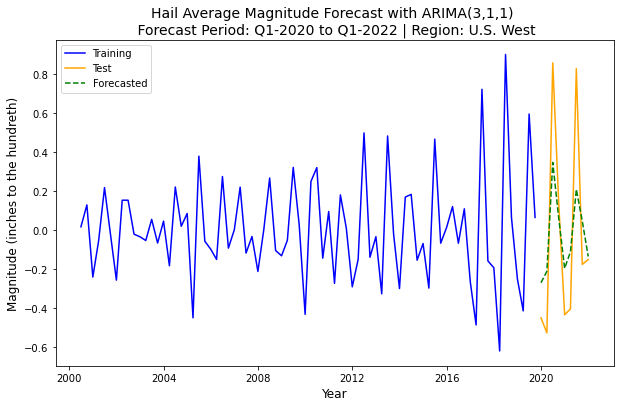

In [38]:
# Hail Average Magnitude Forecast with ARIMA(3,1,1) - Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. West

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Hail Average Magnitude Forecast with ARIMA(3,1,1) \n Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. West', fontsize=14)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Magnitude (inches to the hundreth)', fontsize=12)

plt.legend();

Visually, the model seems to have forecasted decently. It does attempt to follow the increases and decreases, though not to their full extent.

### 5.5. Test Evaluation

In [28]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: 0.5792630355978391


The model is able to explain 58% of the variability in the data.

In [30]:
rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 0.32948950856965403


In [31]:
hail.describe()

,avg_mag,first_diff
count,87.000000,87.000000
mean,1.029472,-0.000333
std,0.210696,0.302773
min,0.314516,-0.620463
25%,0.914820,-0.166931
50%,1.063438,-0.033597
75%,1.178851,0.147405
max,1.328357,0.902346


The RMSE of 0.33 exceeded the standard deviation of 0.30. This model's forecasts are not reliable by these evaluation metric's standards.